# SIR-Macro Model


The main focus of this project is to recreate the model SIR-Macro model introduced in "The Macroeconomics of Epidemics" by Eichenbaumn, Rebelo, Trabandt that we looked at in class.

<a id='contents'></a>

---

# Contents

**1. [The Pre-infection Economy](#pre-infection-econ)**

**2. [The SIR-Macro Model](#SIR-model)**

**3. [Epidemic Dynamics](#epidemic-dynamics)**

**4. [Household Dynamics Results](#household-results)**

**5. [Epidemic Simulation](#ee-sim)**



<br>

### Appendices
* **[Appendix A:](#appendix-pre-infection)** FOC of Pre-infection Agent

* **[Appendix B:](#appendix-recovered)** FOC of Recovered Agent

* **[Appendix C:](#appendix-infected)** FOC of Infected Agent

* **[Appendix D:](#appendix-susceptible)** FOC of Susceptible Agent


<!--
**#. [name](#tag)**


<a id='dynamics-results'></a>

---
[**Back to Contents**](#contents)
 -->

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# formatting
textbf = lambda x: '\033[5m' + str(x) + '\033[0m'

<a id="pre-infection-econ"></a>

---
[**Back to Contents**](#contents)


# 1: The Pre-infection Economy


### Households

Representative household maximizes life-time utility:
$$
\begin{equation*}
    U_{t} = \sum_{t=0}^{\infty} \beta^t u(c_t, n_t) = u(c_t, n_t) + \beta U_{t+1}
\tag{1.1}
\end{equation*}
$$
where $\beta \in (0, 1)$ is the discount factor, $c_t$ is consumption, and $n_t$ is labor (hours worked).


The household has the utility function:
$$
\begin{equation*}
    u(c_t, n_t) = \ln(c_t) - \frac{\theta}{2}n^2_t.
\tag{1.2}
\end{equation*}
$$

The household's budget constraint is
$$
\begin{equation*}
        (1 + \mu_t)c_t = w_t n_t + \Gamma_t,
\tag{1.3}
\end{equation*}
$$


where $w_t$ is wage rate, $\mu_t$ is tax rate on consumption, and $\Gamma_t$ is transfer from the government.


---
### Firms

Continuum of representative firm produces consumption goods $C_t$ with labor $N_t$ and technology $A$:

$$
\begin{align}
    C_t = A N_t
\end{align}
$$

and chooses labor to maximize profits:

$$
\begin{align}
    \Pi_t = A N_t - w_t N_t
\end{align}
$$


### Government

Government's budget constraint is given by:
$$
\begin{align}
    \mu_t c_t = \Gamma_t
\end{align}
$$


$$
\begin{align}
\end{align}
$$


### Market Equilibrium

In equilibrium, $N_t = n_t$ and $c_t = C_t$. Household constraint in equilibrium, by equation (1.3):

$$
\begin{align}
    (1 + \mu_t)c_t &= w_t n_t + \Gamma_t \\
    (1 + \mu_t)c_t &= w_t n_t + \mu_t c_t \\
    (1 + \mu_t - \mu_t)c_t &= w_t n_t \\
    c_t &= w_t n_t \\
\end{align}
$$

In equilibrium, $c_t = C_t = A N_t$, and $ N_t = n_t$. Therefore we have that:
$$
\begin{align}
    c_t &= w_t n_t \\
    A N_t &= w_t n_t \\
    A &= w_t \tag{1.4}
\end{align}
$$

Therefore, consumption in equilibrium is give by <b>(?)</b>:
$$
\begin{equation*}
    c_t = A n_t 
\end{equation*}
$$

### First Order Conditions

The agent has the following first order conditions:

$$
\begin{align}
    \lambda_t &= \frac{\beta^t}{c_t (1 + \mu_t)} \tag{A1} \\
    \lambda_t &= \beta^t \theta n_t \frac{1}{w_t} \tag{A2} \\
    (1 + \mu_t) \theta n_t &= \frac{w_t}{c_t} \tag{A3}
\end{align}
$$

Therefore, subsituting $A$ for $w_t$ in 1.4, in equilibrium we have that

$$
\begin{align}
    c_t &= \frac{A}{(1 + \mu_t) \theta n_t} \tag{1.5}
\end{align}
$$

See **[Appendix A](#appendix-pre-infection)** for derivations of first order conditions.



### Model Set-up

In [3]:
# model parameters

β = 0.96**(1/52) # discount rate
A = 39.835       # technology

# labor statespace
n_states = 1000
n_grid = np.linspace(0, 100, n_states)

# labor aversion parameter
θ_default = 1.275e-3

# tax rate state-space
μ_grid = np.linspace(0, 1)

In [4]:
@njit
def u(c, n, θ=θ_default):
    '''
    Utility function, by equation (1.2). Returns float.
    
    Parameters
    ----------
        c : float
            consumption grid    
            
        n : float
            labor grid
            
        θ : float
            labor aversion
    '''
    res = np.log(c) - (θ/2) * n**2
    
    # for NaN values
    res = -1e10 if np.isnan(res) else res
    res = -1e10 if res == -np.inf else res
    
    return res

@njit
def u_vec(c_grid, n_grid, θ=θ_default):
    '''
    Utility function, by equation (1.2). Returns numpy array.
    
    Parameters
    ----------
        c_grid : array or float
            consumption grid    
            
        n_grid : array or float
            labor grid
            
        θ : float
            labor aversion
    '''
    res = np.log(c_grid) - (θ/2) * n_grid**2
    
    # for NaN values
    res[np.isnan(res)]  == -1e10
    res[res == -np.inf] == -1e10
        
    return res

### Check Uility Function

Below we look at how the utility function behaves with changing labor aversion $\theta$ and wage $w_t$.

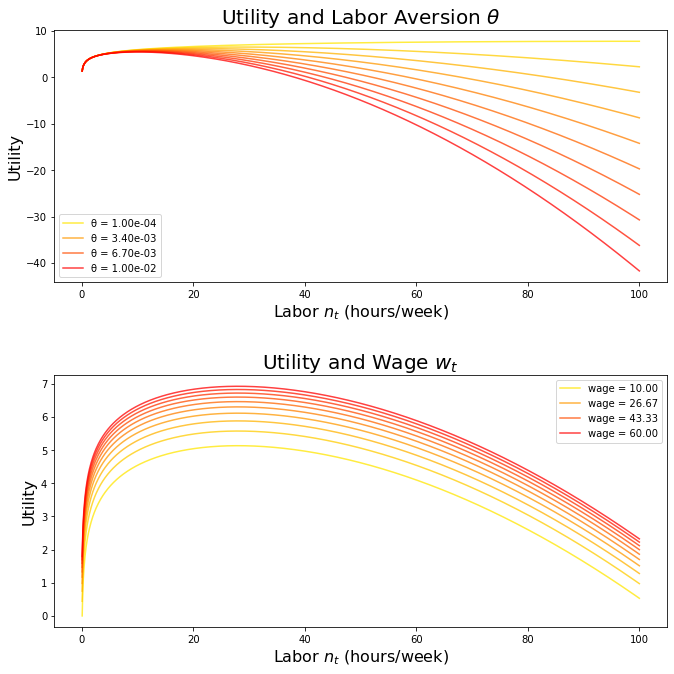

In [5]:
# check out utility function

# formatting

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
cmap = plt.get_cmap('autumn_r') # color map
steps = 10


# utility function and labor aversion

θ_min, θ_max = 1e-4, 1e-2
θ_grid = np.linspace(θ_min, θ_max, steps)

for θ in θ_grid:

    # equilibrium consumption, by equation (1.4)
    c_grid =  A * n_grid
    u_grid = u_vec(c_grid, n_grid, θ=θ)

    # plotting arguments
    scale = 0.1 + 0.9 * (θ-θ_min)/(θ_max-θ_min)
    kwargs = dict(c = cmap(scale), alpha = 0.75)
    
    # add label for first and last
    if θ in (θ_min, θ_max, *θ_grid[::int(steps/3)]):
        
        kwargs['label'] = f'θ = {θ:.2e}'
        
    # plot utility function
    axes[0].plot(n_grid, u_grid, **kwargs)

axes[0].set_title('Utility and Labor Aversion $\\theta$', fontsize=20)

axes[0].set_xlabel('Labor $n_t$ (hours/week)', fontsize=16)
axes[0].set_ylabel('Utility', fontsize=16)

axes[0].legend()


# utility function and wage

w_min, w_max = 10, 60
w_grid = np.linspace(w_min, w_max, steps)

for w in w_grid:

    # equilibrium consumption, by equation (1.4)
    c_grid =  w * n_grid
    u_grid = u_vec(c_grid, n_grid)

    # plotting arguments
    scale = 0.1 + 0.9 * (w-w_min)/(w_max-w_min)
    kwargs = dict(c = cmap(scale), alpha = 0.75)
    
    # add label for first and last
    if w in (w_min, w_max, *w_grid[::int(steps/3)]):
        
        kwargs['label'] = f'wage = {w:.2f}'
        
    # plot utility function
    axes[1].plot(n_grid, u_grid, **kwargs)

axes[1].set_title('Utility and Wage $w_t$', fontsize=20)

axes[1].set_xlabel('Labor $n_t$ (hours/week)', fontsize=16)
axes[1].set_ylabel('Utility', fontsize=16)
axes[1].legend()


plt.tight_layout(pad=3)
plt.show()

### Solve Pre-Infection Economy Model

In [6]:
# solve pre-infection model

@njit
def solve_pre_infection(max_iter=10_000, # max iterations
                        threshold=1e-10 # convergence threshold
                       ):
    '''
    Solves value function and optimal policies for pre-infection economy representative agent.
    
    Parameters
    ---------
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-10)
            convergence threshold of value function
            
    Returns
    -------
        V : float
            value function at convergence
            
        n : float
            optimal labor policy
            
        c : float
            optimal consumption policy
        
        error : float
            convergence error of value function
    '''
    # value-to-go
    V = 0
    
    # consumption grid (by equation 1.4)
    c_grid = A * n_grid
    
    # utility grid
    u_grid = u_vec(c_grid, n_grid)
    
    for _ in range(max_iter):

        # value-to-go in new iteration
        V_prev = V

        # value grid
        v_grid = u_grid + β * V_prev

        # optimal labor choice
        best = np.argmax(v_grid)

        # update value-to-go
        V = v_grid[best]

        # convergence error
        error = np.abs(V - V_prev)
        
        if error < threshold:
            break
    
    # return optimal policy
    return V, n_grid[best], c_grid[best], error

In [7]:
# pre-infection economy policy

V, n, c, error = solve_pre_infection()

print(textbf('Pre-infection Economy'))
print(textbf('-'*30))

print(f'Convergence value: \t {V:.2f}')
print(f'Optimal labor: \t\t {n:.2f} hrs/week')
print(f'Optimal consumption: \t $ {c:.2f}/week')

print(f'\nConvergence error: \t {error:.5f}')

Pre-infection Economy
------------------------------
Convergence value: 	 8301.72
Optimal labor: 		 28.03 hrs/week
Optimal consumption: 	 $ 1116.50/week

Convergence error: 	 0.00254


<a id="SIR-model"></a>

---
[**Back to Contents**](#contents)

# 2: The SIR-Macro Model

### Transmission Rate
Total newly infected population:

$$
\begin{equation*}
        T_t = \pi_1(S_t C^s_t)(I_t C^I_t) + \pi_2 (S_t N^S_t)(I_t N^I_t) + \pi_3 S_t I_t \tag{2.1}
\end{equation*}
$$

where $S_t C^s_t$ and $I_t C^I_t$ are respectively total consumption of the susceptible and infected. $\pi_1$ is the probability of infection from consumption interactions (e.g., when shopping).

$S_t N^s_t$ and $I_t N^I_t$ are total labor of the susceptible and infected. $\pi_2$ is the probability of infection from labor interactions (e.g., at work).

$S_t$ and $I_t$ are percentage population of the susceptible and infected. $\pi_3$ is the probability of infection from other interactions.


### Dynamics of Population

Evolution of susceptible $S_t$, infected $I_t$, recovered $R_t$, and deceased $D_t$ population:

$$
\begin{align}
    S_{t+1} &= S_{t} - T_{t} \tag{2.2} \\
    I_{t+1} &= I_{t} + T_{t} - (\pi_r + \pi_d) I_{t} \tag{2.3} \\
    R_{t+1} &= R_{t} + \pi_r I_{t} \tag{2.4} \\
    D_{t+1} &= R_{t} + \pi_d I_{t} \tag{2.5} \\
\end{align}
$$

Evolution of total population $Pop_{t}$, where $Pop_0 = 1$:
$$
    Pop_{t+1} = Pop_{t} - \pi_d I_{t} \tag{2.6}
$$

### Simulation

Progression of epidemic is simulated with the SIR-Maro Model in [**Section 5**](#ee-sim).

<a id="epidemic-dynamics"></a>

---

[**Back to Contents**](#contents)

# 3: Epidemic Dynamics

For each household type $j \in {s, i, r}$, the budget constraint is similar to pre-infection economy:

$$
\begin{equation*}
    (1 + \mu_t)c^j_t = w_t \phi^j n^j_t + \Gamma_t
\label{eq:const} \tag{3.1}
\end{equation*}
$$

where $c^j_t$ and $n^j_t$ are consumption and labor for type $j$ households, and $\phi^j$ is productivity. We assume that susceptible and recovered households are fully productive $\phi^s = \phi^r = 1$, and infected households are not $\phi^i < 1$.

In [8]:
# model parameters

# infection probabilities
π_1 = 7.84e-8 # from consumption (shopping)
π_2 = 1.24e-4 # from labor (working)
π_3 = 0.39    # from normal interaction

π_r = 0.2  # recovery rate
π_d = 7 * 0.005/18 # mortality rate

# discount rate and wage
β = 0.96**(1/52) # discount rate
A = 39.835  # technology/wage in equilibrium

# labor choice
n_states = 1000
n_grid = np.linspace(0, 100, n_states)

<a id="recovered"></a>

## Recovered Agent

The lifetime utiltiy of a recovered agent is given by:

$$
\begin{equation*}
    U^r_t = u(c^r_t, n^r_t) + \beta U^r_{t+1}
\label{eq:u_s} \tag{R1}
\end{equation*}
$$


First order conditions are detailed in [**Appendix B**](#appendix-recovered).

In [9]:
# recovered policy

@njit
def solve_recovered(ϕ=1.0, # productivity
                    max_iter=10_000, # maximum iterations
                    threshold=1e-5 # convergence threshold
                   ):
    '''
    Solves value function and optimal policies for the recovered representative agent in an epidemic.
    
    Parameters
    ---------
        ϕ : float (default = 1.0)
            labor productivity from equation (3.1)
        
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-10)
            convergence threshold of value function
            
    Returns
    -------
        Vr : float
            recovered agent value at convergence
            
        nr : float
            optimal labor policy
            
        cr : float
            optimal consumption policy
        
        error : float
            convergence error of value function
    '''
    
    # value-to-go
    Vr = 0
    
    # consumption grid
    cr_grid = A * ϕ * n_grid
    
    # current period utility grid
    ur_grid = u_vec(cr_grid, n_grid)
    
    for _ in range(max_iter):

        # previous iteration
        V_prev = Vr

        # value grid, by equation (R1)
        v_grid = ur_grid + β * V_prev

        # optimal policy index
        best = np.argmax(v_grid)

        # update value-to-go
        Vr = v_grid[best]

        # check convergence
        error =  np.abs(Vr - V_prev)
        
        if error < threshold:
            break
            
    # optimal labor and consumption
    nr = n_grid[best]
    cr = cr_grid[best]
    
    return Vr, nr, cr, error

<a id="infected"></a>

## Infected Agent

The lifetime utiltiy of a infected agent is given by:

$$
\begin{equation*}
    U^i_t = u(c^i_t, n^i_t) + \beta [(1 - \pi_r - \pi_d) U^i_{t+1} + \pi_r U^r_{t+1} + \pi_d U^d]
\label{eq:u_s} \tag{I1}
\end{equation*}
$$

We assume life-time utility of deceased agent $U^d$ to be zero. 

First order conditions are detailed in [**Appendix C**](#appendix-infected).

In [10]:
# infected policy

@njit
def solve_infected(Vr, # recovered value
                   Vd=0, # deceased value
                   ϕ=0.8, # productivity
                   max_iter=10_000, # maximum iterations
                   threshold=1e-5 # convergence threshold
                  ):
    '''
    Solves value function and optimal policies for the infected representative agent in an epidemic.
    
    Parameters
    ---------
        Vr : float
            value of recovered agent
            
        Vd : float (default = 0)
            value of deceased agent
        
        ϕ : float (default = 0.8)
            labor productivity from equation (3.1)
            
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-10)
            convergence threshold of value function
            
    Returns
    -------
        Vi : float
            infected agent value at convergence
            
        ni : float
            optimal labor policy
            
        ci : float
            optimal consumption policy
        
        error : float
            convergence error of value function
    '''

    # value-to-go
    Vi = 0
    
    # consumption grid
    ci_grid = A * ϕ * n_grid
    
    # current period utility grid
    ui_grid = u_vec(ci_grid, n_grid)
    
    
    for _ in range(max_iter):

        # previous iteration
        V_prev = Vi

        # value grid, equation (I1)
        v_grid = ui_grid + β * ((1 - π_r - π_d) * V_prev + π_r * Vr + π_d * Vd)

        # optimal policy index
        best = np.argmax(v_grid)

        # update value-to-go
        Vi = v_grid[best]

        # check convergence
        error =  np.abs(Vi - V_prev)
        
        if error < threshold:
            break
            
    # optimal labor and consumption
    ni = n_grid[best]
    ci = ci_grid[best]
            
    return Vi, ni, ci, error

<a id="susceptible"></a>

## Susceptible Agent

The lifetime utiltiy of a susceptible agent is given by:

$$
\begin{equation*}
    U^s_t = u(c^s_t, n^s_t) + \beta [(1 - \tau_t) U^s_{t+1} + \tau_t U^i_{t+1}]
\label{eq:u_s} \tag{S1}
\end{equation*}
$$

where $\tau_t$ is the probability of a susceptible person becoming infected:

$$
\begin{equation*}
    \tau_t = \pi_1 c^s_t (I_t C^I_t) + \pi_2 n^s_t (I_t N^I_t) + \pi_3 I_t
\label{eq:tau} \tag{S2}
\end{equation*}
$$

First order conditions are detailed in [**Appendix D**](#appendix-susceptible).

In [11]:
# susceptible policy

@njit
def solve_susceptible(Vi, # value of infected
                      ϕ=1.0,
                      size=(101, 101), # number of infected and susceptible states
                      max_iter=10_000, # maximum iterations
                      threshold=1e-2 # convergence threshold
                     ):
    '''
    Solves value function and optimal policies for the susceptible representative agent in an epidemic.
    
    Parameters
    ---------
        Vi : float
            value of infected agent
        
        ϕ : float (default = 0.8)
            labor productivity from equation (3.1)
            
        size : tuple (default = (100, 100))
            size of outputs and granularity of (infected, susceptible) statespaces
            
        max_iter : int (default = 10_000)
            max iterations for solving model
            
        threshold : float (default = 1e-2)
            convergence threshold of value function
            
    Returns
    -------
        Vs : numpy array
            value at convergence
            
        Ns : numpy array
            optimal labor policy
            
        Cs : numpy array
            optimal consumption policy
        
        I_grid : numpy array
            statespace of infected population
            
        S_grid : numpy array
            statespace of susceptible population
            
        error : float
            convergence error of value function    
    '''
    
    I_states, S_states = size
    
    # infected population statespace
    I_grid = np.linspace(0, 1, I_states)

    # susceptible population statespace
    S_grid = np.linspace(0, 1, S_states)

    # consumption grid
    cs_grid = A * ϕ * n_grid
    
    # current period utility grid
    us_grid = u_vec(c_grid, n_grid)
    
    # value-to-go function
    Vs = np.zeros(size) 

    # policy functions
    Cs = np.zeros(size)
    Ns = np.zeros(size)
    
    for _ in range(max_iter):

        # previous iteration
        V_prev = Vs.copy()

        # for each infected state
        for i in range(I_states):

            # for each susceptible state
            for j in range(S_states):
                
#                 # reduce runtime by ignoring cases over 110% of population (I + S > 1.1)
#                 if I_grid[i] + S_grid[j] > 1.1:
                    
#                     continue # skip iteration
                
                # calculate transmission rate, by equation (S2)
                τ = π_1 * Cs[i, j] * (I_grid[i] * ci) + π_2 * Ns[i, j] * (I_grid[i] * ni) + π_3 * I_grid[i]

                # new transmitted next period, by equation (2.1)
                T = τ * S_grid[j]

                # find next-period infected population index
                I_prime = min((1 - π_r - π_d) * I_grid[i] + T, 1.0)
                i_prime = np.searchsorted(I_grid, I_prime)

                # find next-period susceptible population index
                S_prime = min(S_grid[j] - T, 1.0)
                j_prime = np.searchsorted(S_grid, S_prime)

                # value function, by equation (S1)
                v_grid = us_grid + β * ((1 - τ) * V_prev[i_prime, j_prime] + τ * Vi)

                # optimal policy index
                best = np.argmax(v_grid)

                # update value-to-go
                Vs[i, j] = v_grid[best]

                # optimal labor and consumption
                Ns[i, j] = n_grid[best]
                Cs[i, j] = c_grid[best]

        # check convergence
        error =  np.abs(Vs - V_prev).sum()
        
        if error < threshold:
            break
                
    return Vs, Ns, Cs, I_grid, S_grid, error
        

<a id='household-results'></a>

---
[**Back to Contents**](#contents)

# 4: Household Dynamics Results

### Pre-Infection Agent Policy

In [12]:
%%time

# pre-infection economy
V, n, c, error = solve_pre_infection()

print(textbf('\nPre-infection Economy'))
print(textbf('-'*30))

print(f'Convergence value: \t {V:.2f}')
print(f'Optimal labor: \t\t {n:.2f} hrs/week')
print(f'Optimal consumption: \t $ {c:.2f}/week')

print(f'\nConvergence error: \t {error:.2e}')


Pre-infection Economy
------------------------------
Convergence value: 	 8301.72
Optimal labor: 		 28.03 hrs/week
Optimal consumption: 	 $ 1116.50/week

Convergence error: 	 2.54e-03
Wall time: 14 ms


### Recovered Agent Policy

In [13]:
%%time

# epidemic: recovered agent
Vr, nr, cr, error = solve_recovered()

print(textbf('\nRecovered Agent Policy'))
print(textbf('-'*30))

print(f'Convergence value: \t {Vr:.2f}')
print(f'Optimal labor: \t\t {nr:.2f} hrs/week')
print(f'Optimal consumption: \t $ {cr:.2f}/week')

print(f'\nConvergence error: \t {error:.2e}')


Recovered Agent Policy
------------------------------
Convergence value: 	 8301.72
Optimal labor: 		 28.03 hrs/week
Optimal consumption: 	 $ 1116.50/week

Convergence error: 	 2.54e-03
Wall time: 522 ms


### Infected Agent Policy

In [14]:
%%time

# epidemic: infected agent
Vi, ni, ci, error = solve_infected(Vr)

print(textbf('\nInfected Agent Policy'))
print(textbf('-'*30))

print(f'Convergence value: \t {Vi:.2f}')
print(f'Optimal labor: \t\t {ni:.2f} hrs/week')
print(f'Optimal consumption: \t $ {ci:.2f}/week')

print(f'\nConvergence error: \t {error:.2e}')


Infected Agent Policy
------------------------------
Convergence value: 	 8221.01
Optimal labor: 		 28.03 hrs/week
Optimal consumption: 	 $ 893.20/week

Convergence error: 	 9.20e-06
Wall time: 549 ms


### Susceptible Agent Policy

In [15]:
%%time
# epidemic: susceptible agent
# this will take quite some time (> 2 minutes)

s_res = solve_susceptible(Vi)

Wall time: 2min 32s


In [16]:
Vs, Ns, Cs, I_grid, S_grid, error = s_res

print(textbf('\nSusceptible  policy found'))
print(textbf('-'*30))

print(f'\nConvergence error: \t {error:.2e}')


Susceptible  policy found
------------------------------

Convergence error: 	 2.73e-01


In [17]:
# labor policy matrix
vsdf = pd.DataFrame(Vs,
                    index=[['Infected Population %']*len(I_grid), I_grid],
                    columns=[['Susceptible Population %']*len(S_grid), S_grid])

print(textbf('Susceptible Agent\'s Value Function'))
step = 10

display(vsdf.iloc[::step, ::step].round(2))

Susceptible Agent's Value Function


Susceptible Population %                             \
                                               0.0      0.1      0.2      0.3   
Infected Population % 0.0                  8823.48  8823.48  8823.48  8823.48   
                      0.1                  8238.32  8231.65  8229.39  8229.10   
                      0.2                  8234.48  8229.95  8227.95  8226.93   
                      0.3                  8231.28  8227.74  8226.48  8225.45   
                      0.4                  8228.85  8225.96  8225.19  8224.52   
                      0.5                  8226.95  8225.16  8224.19  8223.72   
                      0.6                  8225.35  8224.07  8223.53  8223.13   
                      0.7                  8224.31  8223.40  8222.99  8222.68   
                      0.8                  8223.40  8222.82  8222.54  8222.36   
                      0.9                  8222.88  8222.42  8222.27  8222.11   
                      1.0                  8222.43  8222.17  8222.03  8221.95   

                                                                        \
                               0.4      0.5      0.6      0.7      0.8   
Infected Population % 0.0  8823.48  8823.48  8823.48  8823.48  8823.48   
                      0.1  8227.90  8227.31  8226.26  8225.57  8225.07   
                      0.2  8226.10  8225.40  8224.78  8224.21  8223.84   
                      0.3  8225.03  8224.29  8223.84  8223.41  8223.13   
                      0.4  8223.96  8223.48  8223.30  8222.94  8222.74   
                      0.5  8223.25  8223.02  8222.74  8222.55  8222.42   
                      0.6  8222.86  8222.60  8222.42  8222.30  8222.20   
                      0.7  8222.46  8222.30  8222.19  8222.11  8222.03   
                      0.8  8222.20  8222.09  8222.02  8221.95  8221.94   
                      0.9  8222.01  8221.93  8221.91  8221.90  8221.89   
                      1.0  8221.90  8221.89  8221.87  8221.86  8221.84   

                                             
                               0.9      1.0  
Infected Population % 0.0  8823.48  8823.48  
                      0.1  8224.46  8224.09  
                      0.2  8223.52  8223.28  
                      0.3  8222.96  8222.78  
                      0.4  8222.58  8222.46  
                      0.5  8222.30  8222.24  
                      0.6  8222.12  8222.07  
                      0.7  8222.00  8221.98  
                      0.8  8221.94  8221.93  
                      0.9  8221.89  8221.88  
                      1.0  8221.84  8221.83

In [18]:
# labor policy matrix
nsdf = pd.DataFrame(Ns,
                    index=[['Infected Population %']*len(I_grid), I_grid],
                    columns=[['Susceptible Population %']*len(S_grid), S_grid])

print(textbf('Susceptible Agent\'s Labor Policy'))

display(nsdf.iloc[::step, ::step].round(2))

Susceptible Agent's Labor Policy


Susceptible Population %                       \
                                               0.0    0.1    0.2    0.3   
Infected Population % 0.0                    28.03  28.03  28.03  28.03   
                      0.1                    28.03  28.03  28.03  28.03   
                      0.2                    28.03  28.03  28.03  28.03   
                      0.3                    28.03  28.03  28.03  28.03   
                      0.4                    28.03  28.03  28.03  28.03   
                      0.5                    28.03  28.03  28.03  28.03   
                      0.6                    28.03  28.03  28.03  28.03   
                      0.7                    28.03  28.03  28.03  28.03   
                      0.8                    28.03  28.03  28.03  28.03   
                      0.9                    28.03  28.03  28.03  28.03   
                      1.0                    28.03  28.03  28.03  28.03   

                                                                            
                             0.4    0.5    0.6    0.7    0.8    0.9    1.0  
Infected Population % 0.0  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.1  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.2  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.3  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.4  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.5  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.6  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.7  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.8  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      0.9  28.03  28.03  28.03  28.03  28.03  28.03  28.03  
                      1.0  28.03  28.03  28.03  28.03  28.03  28.03  28.03

In [19]:
# consumption policy matrix
csdf = pd.DataFrame(Cs,
                    index=[['Infected']*len(I_grid), I_grid],
                    columns=[['Susceptible']*len(S_grid), S_grid])

print(textbf('\nSusceptible Agent\'s Consumption Policy'))

display(csdf.iloc[::step, ::step].round(2))


Susceptible Agent's Consumption Policy


Susceptible                                               \
                     0.0      0.1      0.2      0.3      0.4      0.5   
Infected 0.0     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.1     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.2     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.3     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.4     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.5     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.6     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.7     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.8     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         0.9     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   
         1.0     1681.68  1681.68  1681.68  1681.68  1681.68  1681.68   

                                                           
                  0.6      0.7      0.8      0.9      1.0  
Infected 0.0  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.1  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.2  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.3  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.4  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.5  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.6  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.7  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.8  1681.68  1681.68  1681.68  1681.68  1681.68  
         0.9  1681.68  1681.68  1681.68  1681.68  1681.68  
         1.0  1681.68  1681.68  1681.68  1681.68  1681.68

In [20]:
def S_policy(policy_grid,
             I_t, S_t, # infection and susceptible
             I_grid=I_grid,
             S_grid=S_grid
            ):
    '''
    Return policy value for susceptible agent.
    '''
    
    # find infected index
    i = np.searchsorted(I_grid, round(I_t, 4))
    
    # find susceptible index
    j = np.searchsorted(S_grid, round(S_t, 4))
    
    # return susceptible agent policy and indices
    return policy_grid[i, j], i, j

<a id='ee-sim'></a>

---
[**Back to Contents**](#contents)

# 5: Epidemic Simulation

Simulating the SIR-Macro model from [**Section 2**](#SIR-model).

In [21]:
H = 60 # periods (weeks)

pop = np.zeros(H)
pop[0] = 1

# susceptible, infected, recovered, deceased
S, I, R, D = (np.zeros(H) for _ in range(4))

# initial distribution
S[0], I[0] = 0.999, 0.001

T = np.zeros(H) # transmission rate

for t in range(H - 1):
    
    # find susceptible agent policy values
    ns, i, j = S_policy(Ns, I[t], S[t]) # labor policy
    cs = Cs[i, j] # consumption policy
    
    # transmission rate, by equation (2.1)
    T[t] = (π_1 * S[t] * cs * I[t] * ci +
            π_2 * S[t] * ns * I[t] * ni +
            π_3 * S[t] * I[t])
    
    # SIR dynamics, equation (2.2 to 2.5)
    S[t + 1] = S[t] - T[t]
    I[t + 1] = (1 - π_r - π_d) * I[t] + T[t]
    R[t + 1] = R[t] + π_r * I[t]
    D[t + 1] = D[t] + π_d * I[t]
    
    # population dyanmics, equation (2.6)
    pop[t + 1] = pop[t] - π_d * I[t]

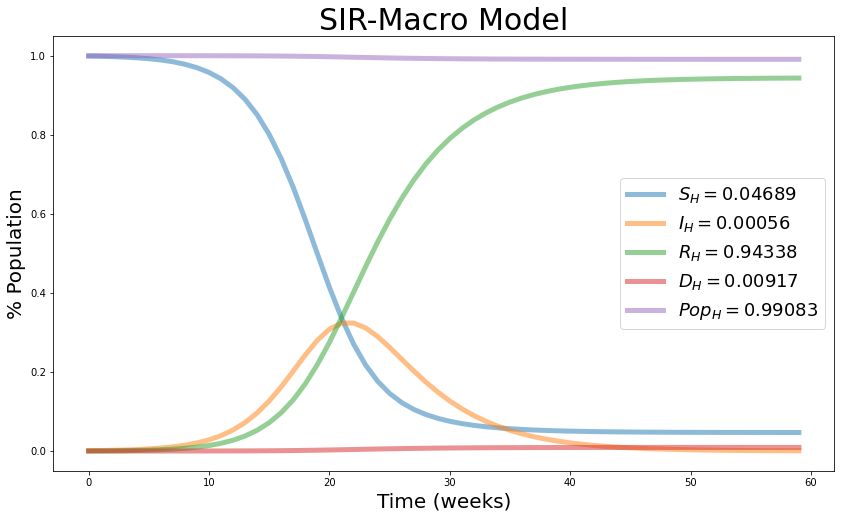

In [22]:
evo_data = np.array([S, I, R, D, pop])
var_names = 'S_{H}, I_{H}, R_{H}, D_{H}, Pop_{H}'.split(', ')

plt.figure(figsize=(14, 8))

for d in evo_data:
    
    plt.plot(range(H), d, alpha=0.5, lw=5)

labels = [f'${l} = {d[-1]:.5f}$' for l, d in zip(var_names, evo_data)]
plt.legend(labels, fontsize=18)

plt.ylabel('% Population', fontsize=20)
plt.xlabel('Time (weeks)', fontsize=20)
plt.title('SIR-Macro Model', fontsize=30)

plt.show()

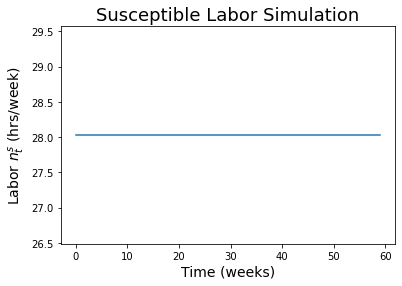

In [23]:
ns_evo = [S_policy(Ns, i, j)[0] for i, j in zip(I, S)]

plt.plot(range(H), ns_evo)

plt.ylabel('Labor $n^s_t$ (hrs/week)', fontsize=14)
plt.xlabel('Time (weeks)', fontsize=14)
plt.title('Susceptible Labor Simulation', fontsize=18)

plt.show()

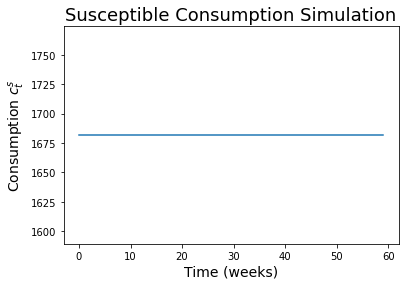

In [24]:
cs_evo = [S_policy(Cs, i, j)[0] for i, j in zip(I, S)]

plt.plot(range(H), cs_evo)

plt.ylabel('Consumption $c^s_t$', fontsize=14)
plt.xlabel('Time (weeks)', fontsize=14)
plt.title('Susceptible Consumption Simulation', fontsize=18)

plt.show()

---

[**Back to Contents**](#contents)


# Appendices

<a id="appendix-pre-infection"></a>

## Appendix A

### First Order Conditions of the [Pre-Infection Economy Agent](#pre-infection-econ)


The Lagrangian is given by:
$$
\begin{align}
    \mathcal{L}
    &= \sum_{t=0}^{\infty} \beta^t u(c_t, n_t) - \lambda_t ((1 + \mu_t)c_t - w_t n_t - \Gamma_t) \\
\end{align}
$$

Taking FOC with respect to $c_t$:
$$
\begin{align}
    0 = \frac{\partial \mathcal{L}}{\partial c_t}
    &= \beta^t \frac{\partial u(c_t, n_t)}{\partial c_t} - \lambda_t (1 + \mu_t) \\
    &= \frac{\beta^t}{c_t} - \lambda_t (1 + \mu_t) \\
    \lambda_t &= \frac{\beta^t}{c_t (1 + \mu_t)} \tag{A1}
\end{align}
$$

Taking FOC with respect to $n_t$:
$$
\begin{align}
    0 = \frac{\partial \mathcal{L}}{\partial n_t}
    &= \beta^t \frac{\partial u(c_t, n_t)}{\partial n_t} + \lambda_t w_t \\
    &= -\beta^t \theta n_t + \lambda_t w_t \\
    \lambda_t &= \beta^t \theta n_t \frac{1}{w_t} \tag{A2}
\end{align}
$$

First order condition, by A1 and A2:
$$
\begin{align}
    \beta^t \theta n_t \frac{1}{w_t} &= \frac{\beta^t}{c_t (1 + \mu_t)} \\
    (1 + \mu_t) \theta n_t &= \frac{w_t}{c_t} \tag{A3}
\end{align}
$$

### First Order Condition in Equilibrium (?)

In market equilibrium, $N_t = n_t$ and $c_t = C_t = A N_t$, which implies $c_t = w n_t = A n_t$ and $w_t = A$. Therefore with (A3) we have that in equilibrium:

$$
\begin{align}
    (1 + \mu_t) \theta n_t &= \frac{w_t}{c_t} \\
    \left( 1 + \mu_t \right) \theta n_t &= \frac{A}{A n_t} \\
    \left( 1 + \mu_t \right) \theta n_t^2 &= 1 \\
    n_t &= \frac{1}{\sqrt{\theta (1 + \mu_t)}}
\end{align}
$$

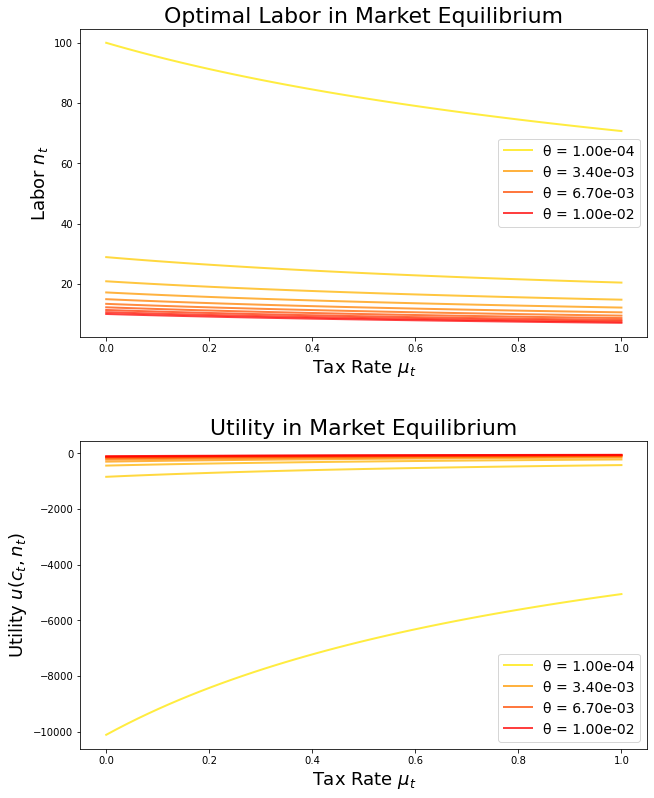

In [25]:
n_optimal = lambda mu, θ=θ_default: 1 / np.sqrt(θ * (1 + mu))

# formatting
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
cmap = plt.get_cmap('autumn_r') # color map
step = 10

# tax rate space
mu_grid = np.linspace(0, 1)

# labor aversion
θ_min = 1e-4
θ_max = 1e-2
θ_grid = np.linspace(θ_min, θ_max, step)

for θ in θ_grid:    
    
    # formatting arguments
    scale = 0.1 + 0.9 * (θ-θ_min)/(θ_max-θ_min)
    formatting = dict(c = cmap(scale), alpha = 0.75, lw=2)
    
    if θ in (θ_min, θ_max, *θ_grid[::int(step/3)]):
        formatting['label'] = f'θ = {θ:.2e}'
    
    # optimal labor
    nop_grid = n_optimal(mu_grid, θ)
    
    # plot labor
    axes[0].plot(mu_grid, nop_grid, **formatting)
    
    # consumption based on equilibrium consumption constraint
    cop_grid = A * nop_grid
    
    # utility
    uop_grid = u_vec(nop_grid, cop_grid)
    
    # plot utility
    axes[1].plot(mu_grid, uop_grid, **formatting)

axes[0].set_xlabel('Tax Rate $μ_t$', fontsize=18)
axes[0].set_ylabel('Labor $n_t$', fontsize=18)
axes[0].set_title('Optimal Labor in Market Equilibrium', fontsize=22)
axes[0].legend(fontsize=14)

axes[1].set_xlabel('Tax Rate $μ_t$', fontsize=18)
axes[1].set_ylabel('Utility $u(c_t, n_t)$', fontsize=18)
axes[1].set_title('Utility in Market Equilibrium', fontsize=22)
axes[1].legend(fontsize=14)

plt.tight_layout(pad=4)
plt.show()

<a id="appendix-recovered"></a>

## Appendix B

### First Order Condition of the [Recovered Agent](#recovered)

The lagrangian is
$$\begin{align}
    \mathcal{L}
    &= u(c^r_t, n^r_t) + \beta U^r_{t+1} - \lambda^r[(1 + \mu_t)c^r_t - w_t \phi^r n^r_t - \Gamma_t]
\end{align}$$


Taking FOC with respect to consumption:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial c^r_t} \\
    &= \frac{\partial u(c^r_t, n^r_t)}{\partial c^r_t} - \lambda^r (1 + \mu_t) \\
    &= \frac{1}{c^r_t} - \lambda^r (1 + \mu_t) \\
    \lambda^r &= \frac{1}{c^r_t (1 + \mu_t)} \tag{B1}
\end{align}
$$

Taking FOC with respect to labor:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial n^r_t} \\
    &= \frac{\partial u(c^r_t, n^r_t)}{\partial n^r_t} + \lambda^r w_t \phi^r \\
    &= -\theta n^r_t + \lambda^r w_t \phi^r \\
    \lambda^r &= \frac{\theta n^r_t}{w_t \phi^r} \tag{B2}
\end{align}
$$

By equations (B1) and (B2), we have
$$
\begin{align}
    \frac{\theta n^r_t}{w_t \phi^r} &= \frac{1}{c^r_t (1 + \mu_t)} \\
    (1 + \mu_t)\theta n^r_t &= \frac{w_t \phi^r}{c^r_t} \tag{B3}
\end{align}
$$

<a id="appendix-infected">(#contents)</a>

## Appendix C

### First Order Condition of the [Infected Agent](#infected)

The lagrangian is
$$\begin{align}
    \mathcal{L}
    &= u(c^i_t, n^i_t) + \beta [(1 - \pi_r - \pi_d) U^i_{t+1} + \pi_r U^i_{t+1} + \pi_d 0] - \lambda^i [(1 + \mu_t)c^i_t - w_t \phi^i n^i_t - \Gamma_t]
\end{align}$$


Taking FOC with respect to consumption:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial c^i_t} \\
    &= \frac{\partial u(c^i_t, n^i_t)}{\partial c^i_t} - \lambda^i(1 + \mu_t) \\
    &= \frac{1}{c^i_t} - \lambda^i(1 + \mu_t) \\
    \lambda^i &= \frac{1}{c^i_t (1 + \mu_t)} \tag{C1}
\end{align}
$$

Taking FOC with respect to labor:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial n^i_t} \\
    &= \frac{\partial u(c^i_t, n^i_t)}{\partial n^i_t} + \lambda^i w_t \phi^i \\
    &= -\theta n^i_t + \lambda^i w_t \phi^i \\
    \lambda^i &= \frac{\theta n^i_t}{w_t \phi^i} \tag{C2}
\end{align}
$$

By equations (C2) and (C3), we have
$$
\begin{align}
    \frac{\theta n^i_t}{w_t \phi^i} &= \frac{1}{c^i_t (1 + \mu_t)} \\
    (1 + \mu_t)\theta n^i_t &= \frac{w_t \phi^i}{c^i_t} \tag{C3}
\end{align}
$$

<a id="appendix-susceptible">(#contents)</a>

## Appendix D

### First Order Condition of the [Susceptible Agent](#susceptible)

The lagrangian is
$$\begin{align}
    \mathcal{L}
    &= u(c^s_t, n^s_t) + \beta [(1 - \tau_t) U^s_{t+1} + \tau_t U^i_{t+1}] \\
    &\quad - \lambda^s_{bt}[(1 + \mu_t)c^s_t - w_t \phi^s n^s_t - \Gamma_t] \\
    &\quad - \lambda_{rt} [\tau_t - \pi_1 c^s_t (I_t C^I_t) - \pi_2 n^s_t (I_t N^I_t) - \pi_3 I_t]
\end{align}$$


Taking FOC with respect to consumption:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial c^s_t} \\
    &= \frac{\partial u(c^s_t, n^s_t)}{\partial c^s_t} - \lambda^s_{bt}(1 + \mu_t) + \lambda_{rt} \pi_1 (I_t C^I_t)
\end{align}
$$

Taking FOC with respect to labor:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial n^s_t} \\
    &= \frac{\partial u(c^s_t, n^s_t)}{\partial n^s_t} + \lambda^s_{bt} w_t \phi^s + \lambda_{rt} \pi_2 (I_t N^I_t)
\end{align}
$$

Taking FOC with respect to infection rate:
$$
\begin{align}
    0
    &= \frac{\partial \mathcal{L}}{\partial \tau_t} \\
    &= \beta (U^i_{t+1} - U^s_{t+1}) -\lambda_{rt}
\end{align}
$$